In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [2]:
amazonData = pd.read_csv('Amazon_Unlocked_Mobile.csv')
amazonData.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [3]:
amazonData = amazonData.dropna(axis=0)

In [4]:
amazonData.shape

(334335, 6)

In [5]:
amazonData = amazonData[["Reviews","Rating"]]

In [6]:
amazonDataPositiveDf = amazonData[amazonData["Rating"].isin([4,5])]
amazonDataNegativeDf = amazonData[amazonData["Rating"].isin([1,2])]
amazonDataNeutralDf = amazonData[amazonData["Rating"].isin([3])]

In [7]:
print('Positive: ', amazonDataPositiveDf.shape)
print('Neutal: ', amazonDataNeutralDf.shape)
print('Negative: ', amazonDataNegativeDf.shape)

Positive:  (230674, 2)
Neutal:  (26058, 2)
Negative:  (77603, 2)


In [8]:
amazonDataFiltered = pd.concat([amazonDataPositiveDf[:20000], amazonDataNeutralDf[:20000], amazonDataNegativeDf[:20000]])

<AxesSubplot:>

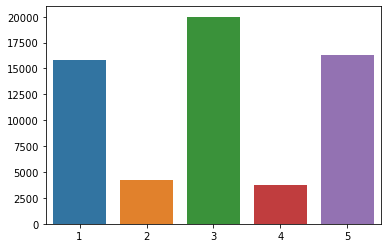

In [9]:
sns.barplot(x=amazonDataFiltered.Rating.value_counts().index, y=amazonDataFiltered.Rating.value_counts().values)

In [10]:
# amazonDataFiltered["Sentiment"] = "Positive"
# amazonDataFiltered["Sentiment"][amazonDataFiltered["Rating"].isin([1,2])]= "Negative"
# amazonDataFiltered["Sentiment"][amazonDataFiltered["Rating"].isin([3])]= "Neutral"

In [11]:
amazonDataFiltered["Sentiment"] = 2 #positive
amazonDataFiltered["Sentiment"][amazonDataFiltered["Rating"].isin([1,2])]= 0 #negative
amazonDataFiltered["Sentiment"][amazonDataFiltered["Rating"].isin([3])]= 1 #neutral

/var/folders/qy/ltftvghn3vb8lhkfmh8m0tx40000gn/T/ipykernel_32727/2616130612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazonDataFiltered["Sentiment"][amazonDataFiltered["Rating"].isin([1,2])]= 0
/var/folders/qy/ltftvghn3vb8lhkfmh8m0tx40000gn/T/ipykernel_32727/2616130612.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazonDataFiltered["Sentiment"][amazonDataFiltered["Rating"].isin([3])]= 1


In [12]:
amazonDataFiltered[20000:20005]
amazonDataFiltered.shape

(60000, 3)

In [13]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

def lower_case(text):
    return text.lower()
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_username(text):
    return re.sub('@[^\s]+','',text)
def remove_urls(text):
    return re.sub(r"((http\S+)|(www\.))",'',text)
def remove_special_characters(text):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern,'',text)
    return text
def remove_single_char(text):
    return re.sub(r'\b[a-zA-Z]\b','',text)
def remove_multiple(text):
    return re.sub("(.)\\1{2,}","\\1",text)
tokenizer = ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    tokens = [token.lower() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_tokens = ' '.join(filtered_tokens)
    return filtered_tokens

In [14]:
import json
with open('contractions.json','r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']
def replace_contractions(text):
    for word in text.split():
        if word.lower()  in contractions:
            text = text.replace(word,contractions[word.lower()])
    return text

In [15]:
with open('negations.json','r') as f:
    neg_dict = json.load(f)
negations = neg_dict['negations']

#Antonyms
#Negation Handler
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
# from nltk.
class AntonymReplacer(object):
    def replace(self,word):
        antonyms = set()
        for syn in wordnet.synsets(word):
            if syn.pos() in ['a' ,'s']:
                for lemma in syn.lemmas():
                    for antonym in lemma.antonyms():
                        antonyms.add(antonym.name())
        if(len(antonyms) == 1):
            return antonyms.pop()
        else:
            if word in negations:
                word = word.replace(word,negations[word])
                return word
        
    #Negation Replacer
    def negReplacer(self, string):
        i=0
        finalSent = ""
        sent = word_tokenize(string)
        length_sent = len(sent)
        words = []
        while i < length_sent:
            word = sent[i]
            if word == 'not' and i+1 < length_sent:
                antonymWord = self.replace(sent[i+1])
                if antonymWord:
                    words.append(antonymWord)
                    finalSent += antonymWord + " "
                    i += 2
                    continue
            words.append(word)
            finalSent += word + " "
            i += 1
        return finalSent
    
# replacer = AntonymReplacer()
# oppWord = replacer.negReplacer('not recommend')
# print(oppWord)
    
def replace_negation(text):
    
    replacer = AntonymReplacer()
    oppWord = replacer.negReplacer(text)
    return oppWord

# replace_negation('I am heavy')

In [16]:
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(lower_case)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_multiple)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_single_char)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_special_characters)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_square_brackets)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_urls)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_username)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(replace_contractions)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(replace_negation)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_stopwords)

In [17]:
from sklearn.model_selection import train_test_split
X = amazonDataFiltered["Reviews"]
y = amazonDataFiltered["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(type(y_train))

<class 'pandas.core.series.Series'>


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
tfidf_vector = TfidfVectorizer()
#tfidf_vector = TfidfVectorizer()
tfidf_vector.fit(X_train)
X_train_data = tfidf_vector.transform(X_train)
X_test_data = tfidf_vector.transform(X_test)
X_train_data = X_train_data.toarray()
X_test_data = X_test_data.toarray()
pd.DataFrame(X_train_data, columns=tfidf_vector.get_feature_names())
# print(X_train_data)

,aa,aac,aactivate,aahs,aand,aanother,aaps,aarp,ab,aback,...,zones,zoom,zooming,zooms,zoverall,zsound,ztd,zte,zumbido,zune
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# from sklearn.feature_extraction.text import CountVectorizer
# count_vector = CountVectorizer()
# count_vector.fit(X_train)
# X_train_data = count_vector.transform(X_train)
# X_test_data = count_vector.transform(X_test)
# X_train_data = X_train_data.toarray()
# X_test_data = X_test_data.toarray()
# pd.DataFrame(X_test_data[2:6], columns=count_vector.get_feature_names())

In [116]:
class naiveBayes:
    def predict(self, X_test_data):
        y_pred = [self._predict(x, self.log_probabilities, self.class_count) for x in X_test_data]
#         print (y_pred)
        return y_pred
    
    def _predict(self, query_point,log_probabilities,classes):
        # Calculating posterior probabilities
        output = np.matmul(log_probabilities,query_point.T)
        # Finding the index using argmax i.e. index of highest probabilty and returing the specified class.
        index = np.argmax(output)
        #print(index)
        return index
    
    def fit(self, X_train_data, y_train):
        n_samples, n_features = X_train_data.shape
        self._classes = np.unique(y_train)
        y_train = np.array(y_train)
        lb = preprocessing.LabelBinarizer()
        y_train = lb.fit_transform(y_train)
        self.count_matrix = np.matmul(y_train.T,X_train_data)
        self.class_count = y_train.sum(axis=0)
        n_classes = len(self._classes)
#         print(self.class_count)
        
        def calculate_prior_probs(class_count):
            # class count - [8,10]
            # probabilities will be 8/18, 10/18
            # And we apply log operation on to them.
            num = class_count
#             print(num)
            den = class_count.sum()
#             print(den)
            prob = np.log(num)-np.log(den)
#             print(prob)
            return prob

        def feature_log_probabilities(count_matrix, prior_prob):
            alpha=1
            # Adding alpha to the count
            smoothed_version = count_matrix+alpha
#             print(smoothed_version)
            # Calculating the number of words in a given class
            den = smoothed_version.sum(axis = 1)
            # Reshaping it to 2D column
            den = den.reshape(-1,1)
            # probability is num/den -- log probability is log(num)- log(den)
            #this is conditional probability
            log_probabilities = np.log(smoothed_version)-np.log(den)
            print('Manually implemented log-probabilities\n')
            print(log_probabilities)
            #adding log of conditional probabilities and prior probabilities to find posterior probabilities
            def prior_prob_integration(conditional_probabilities):
                for idx, x in enumerate(conditional_probabilities):
                    for k, y in enumerate(self.prior_prob):
                        if (idx == k):
                            x += y
                return conditional_probabilities
            posterior_probabilities = prior_prob_integration(log_probabilities)
            return posterior_probabilities
        self.prior_prob = calculate_prior_probs(self.class_count)
        self.log_probabilities = feature_log_probabilities(self.count_matrix, self.prior_prob)  
        print('Manually implemented prior probabilities\n')
        print(self.prior_prob)
        print('Manually implemented posterior-probabilities\n')
        print(self.log_probabilities)

In [117]:
from sklearn.naive_bayes import MultinomialNB
MNB = naiveBayes()
#MNB = MultinomialNB()
MNB.fit(X_train_data, y_train)
print('Manual predict', MNB.predict(X_test_data[0:1]))
predictions = MNB.predict(X_test_data)

Manually implemented log-probabilities

[[-11.35014962 -11.35014962 -11.35014962 ... -10.56869904 -11.35014962
  -11.35014962]
 [-11.30144148 -11.15963438  -9.85516006 ... -11.03196231 -11.31684525
  -10.48145913]
 [-10.90393903 -11.17870635 -11.17870635 ... -10.93773846 -11.17870635
  -11.17870635]]
Manually implemented prior probabilities

[-1.09630246 -1.09917495 -1.10036382]
Manually implemented posterior-probabilities

[[-12.44645208 -12.44645208 -12.44645208 ... -11.6650015  -12.44645208
  -12.44645208]
 [-12.40061643 -12.25880933 -10.954335   ... -12.13113726 -12.4160202
  -11.58063407]
 [-12.00430285 -12.27907017 -12.27907017 ... -12.03810229 -12.27907017
  -12.27907017]]
Manual predict [1]


In [119]:
from sklearn.naive_bayes import MultinomialNB
#MNB = naiveBayes()
MNB1 = MultinomialNB()
MNB1.fit(X_train_data, y_train)
predictions1 = MNB1.predict(X_test_data)
# predictions = MNB.predict(X_test_data[122:124])
# print(predictions)
print('Sklearn feature log-probabilities\n',MNB1.feature_log_prob_)
# Comparing predict function
print('Sklearn prior probabilities\n',MNB1.class_log_prior_)
print('Sklearn predict',MNB1.predict(X_test_data[0:1]))

Sklearn feature log-probabilities
 [[-11.35014962 -11.35014962 -11.35014962 ... -10.56869904 -11.35014962
  -11.35014962]
 [-11.30144148 -11.15963438  -9.85516006 ... -11.03196231 -11.31684525
  -10.48145913]
 [-10.90393903 -11.17870635 -11.17870635 ... -10.93773846 -11.17870635
  -11.17870635]]
Sklearn prior probabilities
 [-1.09630246 -1.09917495 -1.10036382]
Sklearn predict [1]


In [98]:
from sklearn.metrics import accuracy_score, classification_report
print('Train accuracy of manual model: ',accuracy_score(y_train, MNB.predict(X_train_data)))
print('Test accuracy of manual model:', accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Train accuracy of manual model:  0.8294375
Test accuracy of manual model: 0.80425
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      3963
           1       0.75      0.74      0.75      4009
           2       0.86      0.84      0.85      4028

    accuracy                           0.80     12000
   macro avg       0.80      0.80      0.80     12000
weighted avg       0.80      0.80      0.80     12000



In [99]:
from sklearn.metrics import accuracy_score, classification_report
print('Train accuracy: ',accuracy_score(y_train, MNB1.predict(X_train_data)))
print('Test accuracy:', accuracy_score(y_test, predictions1))
print(classification_report(y_test, predictions1))

Train accuracy:  0.8293541666666666
Test accuracy: 0.8040833333333334
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      3963
           1       0.75      0.74      0.75      4009
           2       0.86      0.84      0.85      4028

    accuracy                           0.80     12000
   macro avg       0.80      0.80      0.80     12000
weighted avg       0.80      0.80      0.80     12000



In [61]:
X_test

165174    aware g gsm phone activate maybe would gophone...
300073    well ended getting two one husband mine arrive...
21754                                hope iphone six better
31104     phones screen broke right away keeps cracking ...
34585     thank wonderful phone giving phone gift really...
                                ...                        
103644    bought phone cheap replacement boyfriend broke...
20822      worked great transfered information wham good go
32625     phone worked perfectly minimal scratches satis...
111014                                               normal
13033     disappointed phone spent around hours another ...
Name: Reviews, Length: 12000, dtype: object

In [62]:
list_of_tuples = list(zip(X_test[2:6], predictions))
pd.DataFrame(list_of_tuples, columns = ['Text', 'Sentiment'])

,Text,Sentiment
0,hope iphone six better,1
1,phones screen broke right away keeps cracking ...,1
2,thank wonderful phone giving phone gift really...,2
3,phone perfect send headphones charger genericn...,0


In [105]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions1)

# it shoes that out of 1012 data, 112 data that are acutally positive is predicted as negative

array([[3302,  527,  134],
       [ 606, 2978,  425],
       [ 206,  453, 3369]])

In [65]:
text1 = [
#         'Will not repurchase. Do not recommend',
#        'I hate this',
#        'I love this',
#        'This is not worth it',
#        'This is not terrible',
#        'This product so far has not disappointed',
        'Excellent product. Easy to use, large screen makes watching movies and reading easier.',
        'I am so happy today',
       'Note 10 has great camera quality. I am loving it.',
       'I dont know what is wrong with this phone. I have been trying to type but its not working.',
       'Dell laptop battery dead',
        'Good, but unhappy that screen size is small, less than I expected',
       'The product has not disappointed',
       'It is a expensive phone',
       'I hate apple',
        'less expensive than last year with so many more features and bigger screen!',
        'I do not enjoy working under tight deadline',
        'worst phone in the history',
        'phone is not good but has nice screen'
]
# print(text1)
text_df1 = pd.DataFrame(text1,columns=['text'])
# print(text_df1)


In [66]:
text_df1['text'] =text_df1['text'].apply(lower_case)
text_df1['text'] =text_df1['text'].apply(remove_multiple)
text_df1['text'] =text_df1['text'].apply(remove_single_char)
text_df1['text'] =text_df1['text'].apply(remove_special_characters)
# text_df1['text'] =text_df1['text'].apply(remove_stopwords)
text_df1['text'] =text_df1['text'].apply(remove_square_brackets)
text_df1['text'] =text_df1['text'].apply(remove_urls)
text_df1['text'] =text_df1['text'].apply(remove_username)
text_df1['text'] =text_df1['text'].apply(replace_contractions)
text_df1['text'] =text_df1['text'].apply(replace_negation)
# text_df1['text'] =text_df1['text'].apply(remove_stopwords)

In [68]:
text=tfidf_vector.transform(text_df1['text'])

In [69]:
sample_sentences = [
    'I like this phone', 
    'The screen is small in this phone', 
    'I prefer big screen over small in a phone'
    ]

In [70]:
tfidf = TfidfVectorizer()
vectorizer = tfidf.fit_transform(sample_sentences)
pd.DataFrame(vectorizer.toarray(), columns=tfidf.get_feature_names())


,big,in,is,like,over,phone,prefer,screen,small,the,this
0,0.000000,0.000000,0.000000,0.720333,0.000000,0.425441,0.000000,0.000000,0.000000,0.000000,0.547832
1,0.000000,0.352215,0.463121,0.000000,0.000000,0.273526,0.000000,0.352215,0.352215,0.463121,0.352215
2,0.443503,0.337295,0.000000,0.000000,0.443503,0.261940,0.443503,0.337295,0.337295,0.000000,0.000000
